<font  size = 6> **Regressão Logística** </font>

<font size = 5 >  Conteudo desse Notebook:</font>
<ol>
    <li><a href="#1.">Descrição do Dataset</a></li>
    <li><a href="#2.">Configuração do notebook e os dados</a></li>
    <li><a href="#3.">Pré-processamento dos dados de texto</a></li>
    <li><a href="#4.">Tipos de problemas abordados pelo modelo linear</a></li> 
    <li><a href="#5.">Modelagem do problema de regressão logística</a></li>
    <li><a href="#6.">O algoritmo de Aprendizagem</a></li>
    <li><a href="#7.">Aplicação</a></li>
</ol>

    


<font id="1." color = 'red' size = 4 > *1. Descrição do Dataset*</font>


O data set`Sentimento` consiste em 3000 sentenças oriundas de revisões feitas nos sites `imbd.com`, `amazon.com` e `yelp.com`. Cada sentença é classificada como positiva ou negativa de acordo com a revião, onde o <font color = 'green'> label "1" </font> corresponde a uma <font color = 'green'>revisão positiva </font> e <font color = 'red'>"0" </font>a uma revisão  </font><font color = 'red'>negativa</font>.

Irei usar <font color = 'blue'> **regressão logística** </font> para aprender não apenas a classificar esse conjunto de dados (sentenças) como positivas ou negativas como também predizer com que probabilidade estamos classificando a sentença. 

Os dados estão disponíveis em https://www.kaggle.com/rahulin05/sentiment-labelled-sentences-data-set e foram alocados na pasta `sentiment_labelled_sentences`.O arquivo `full_set.txt` é a união dos datasets do `imbd.com`, `amazon.com` e `yelp.com`, respectivamente.

<font id="2." color = 'red' size = 4 > *2. Configurando o notebook, carregando os dados*</font>


Primeiro, importando pacotes padrões...


In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

Carregando os dados...

In [2]:
## Lendo o data set.
with open("datasets/sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()    
#Removendo os espaços em branco à direita e à esquerda.
content = [x.strip() for x in content]
# Separando as sentenças e  labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]
y = np.array(labels, dtype='int8')

Olhando como os dados de entrada se apresentam...

In [3]:
content [0:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0',
 'Good case, Excellent value.\t1',
 'Great for the jawbone.\t1',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0',
 'The mic is great.\t1',
 'I have to jiggle the plug to get it to line up right to get decent volume.\t0',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.\t0',
 'If you are Razr owner...you must have this!\t1',
 'Needless to say, I wasted my money.\t0',
 'What a waste of money and time!.\t0']

Olhando como as sentenças de apresentam...

In [4]:
sentences[0:5]

['So there is no way for me to plug it in here in the US unless I go by a converter.',
 'Good case, Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.']

##### Olhando para os labels...

In [5]:
y[0:5]

array([0, 1, 1, 0, 1], dtype=int8)

<font id="3." color = 'red' size = 4> 3. Pré-processando os dados de texto</font> 

Para transformar este problema de predição em um exequível problema para a classificação linear, É preciso pré-processar os dados de texto. Para isso 4 transformações serão feitas em 4 passos:

1. Remover pontuações e números.
2. Deixar todas as palavras com letras minúsculas.
3. Remover _stop words_ .
4. Converter as sentenças em vetores, usando uma representação por malas de palavrasa "bag-of-words representation".

Passos 1 e 2

In [6]:
## A função full_remove recebe uma string(sentença) "x" e uma lista de characteres para serem removidos "removal_list" 
## returna x com todos os caracteres contidos na "removal_list" trocados por ' ' ( um espaço)
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remover números
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remover pontuação
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Convertendo todas as letras para minúsculo
sents_lower = [x.lower() for x in punc_less]

Passo 3: Stop Words

Stop words são palavras que filtramos e dispensamos porque acreditamos que não possuam informações úteis para o problema de classificação. Essas palavras são normalmente artigos ("a","as",...), pronomes ("eu","eles",..) e preposições ("para", "de", ...). Iremos usar uma pequena lista de stop words, o que significa que não é a mais abrangente.

In [7]:
## Definindo nossas stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Removendo stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

Visualizando a aparencia das sentenças após os três primeiros passos...

In [8]:
sents_processed[0:5]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great']

Passo 4: Bag Words

Para usar o Classificador linear no conjunto de dados, é preciso transformar os dados de texto em dados numéricos. A forma clássica de se fazer isso é conhecida como a representação por mala de palavras '_bag of words_ representation'. 

Nessa representação, cada palavra é pensada como um número no conjunto `{1, 2, ..., V}` onde `V` é o tamanho do nosso vocabulário (número de palavras diferentes nas 3000 sentenças). E cada sentença é representada como um vetor $x$ de dimensão V, onde cada $x_i$ é o número de vezes que a palavra $i$ aparece na sentença.

Para fazer essa transformação, usarei a classe`CountVectorizer` do `scikit-learn`.Irei limitar o vocabulário ao número máximo de 4500 palavras, isso significa  que uma determinada palavra do nosso conjunto de dados só fará parte do vocabulário se ela fizer parte de uma das 4500 palavras mais frequentes. Essa limitação é um passo comum para lidar com erros de digitação.


Finalmente, adicionarei "1" no final de cada vetor para permitir que o nosso classificador linear consiga lidar com o  bias (dica do yasser)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

## Transformando para a representação de mala de palavras "bag of words representation".
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## adicionando '1' no fim de cada vetor
data_mat = data_features.toarray()

p_mat = data_features.toarray()
data_mat = np.ones((p_mat.shape[0], p_mat.shape[1]+1))
data_mat[:,:-1] = p_mat

In [10]:
data_mat.shape

(3000, 4501)

In [11]:
data_features

<3000x4500 sparse matrix of type '<class 'numpy.int64'>'
	with 27379 stored elements in Compressed Sparse Row format>

Visualizando a representação da primeira sentença

In [12]:
xs = np.array( [ z[0] for z in list(vectorizer.vocabulary_.items())[0:18]])

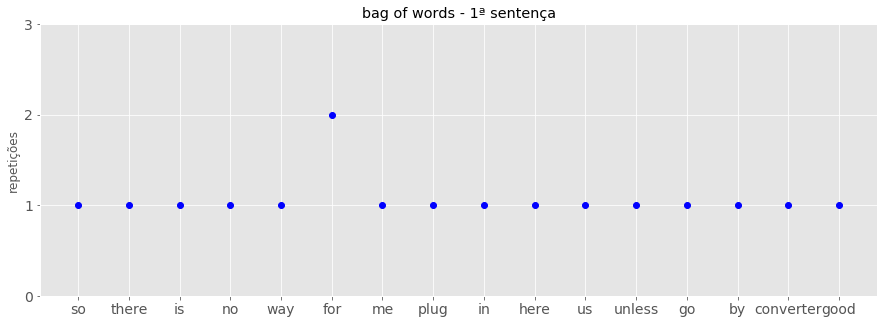

X_is, não nulos do vetor que representa a 1ª sentença	 [(array([ 575,  941, 1694, 1759, 1832, 1896, 1924, 2271, 2437, 2747, 3516,
       3900, 4147, 4189, 4334, 4500]),)]


In [13]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (15,5))
plt.plot(data_mat[0][data_mat[0]!=0],'bo')
plt.xticks(np.arange(0,16),xs)
plt.yticks(np.arange(0,4))
plt.ylabel('repetições')
plt.title('bag of words - 1ª sentença')
plt.show()
print('X_is, não nulos do vetor que representa a 1ª sentença\t',[np.where(data_mat[0]!=0)])



<font id="4." color = 'red' size = 4> *4. Tipos de problemas abordados pelo modelo linear*</font>

<font size =3.5> **O modelo linear pode ser empregado em três classes de problemas, classificados conforme o input e o output.**</font>

<p><font size = 3 color ='blue' > <strong> 1. O problema de classificação</strong> $ g(x):\mathbb{R^n}\longrightarrow(-1,1)$</font></p>

Onde $g(x)$ é a hipotese final que se aproxima da desconhecida $f(x)$, essa função sempre retornará `-1 ou 1` e isso é usado para realizarmos uma classificação binária. Tratando do modelo linear a função $g(x)$ em questão é $sign(<w^T,x>)$, função que analisa o sinal do produto interno do vetor peso `w` com o vetor `x`. O principio dessa classificação está na divisão do domínio $X \epsilon \mathbb{R^n}$ em dois "lados", e assinalar para cada ponto o seu "lado" de acordo com a função $g(x)$. O vetor `w` é o vetor normal que descreve a reta,o planoou o hiperplano que dividem o dominio no $\mathbb{R^2}$,$\mathbb{R^3}$e$\mathbb{R^{n>3}}$,respectivamente. A obtenção de w envolve a aplicação do `PLA` como algoritmo de aprendizado.

<p><font size = 3 color = 'blue'><strong> 2. O problema de regressão Linear</strong> $ g(x):\mathbb{R^n}\longrightarrow\mathbb{R}$</font></p>

Onde $g(x)$ é a hipotese final que se aproxima da desconhecida $f(x)$, essa função sempre retornará um `escalar`. Tratando do modelo linear a função $g(x)$ em questão é $ <w^T.x>$, função que retorna o valor do produto interno entre vetor peso transposto `w^T` com o vetor `x`. A obtenção de w envolve a resolução de um sistema de equações lineares $ \frac{2}{N}X^T(X.w - y)=0$ (onde X é uma matriz que contem todos os vetores x em suas linhas e y é o vetor com todos os labels) obtido da derivação da função erro  $L(w)=\sum_{i = 1}^{N} \frac{1}{N}(y^i - <w^T,x^i>)^2$, estabelecida pelo método de mínimos quadrados.

<p><font size = 3 color = 'blue'><strong> 3. O problema de regressão Logística</strong> $ g(x):\mathbb{R^n}\longrightarrow[0,1]$</font></p>

Onde $g(x)$ é a hipotese final que se aproxima da desconhecida $f(x)$, essa função sempre retornará uma probabilidade `p E [0,1]`. Tratando do modelo linear a função $g(x)$ é uma composição $S(h(x))$ onde $ h(x) = <w^T.x>$ e $S$ qualquer função que leve um escalar ao intervalo de probabilidades [0,1]. 


<font id = "5." color = 'red' size = 4> *5. Modelagem do problema de Regressão Logística*</font> 

No problema de regressão logística, não estamos interessados apenas em classicarmos o conjunto de dados ou em fitarmos a melhor reta, o plano ou o hiperplano que melhor descreve o conjunto de dados. Estamos interessados em medir a `confiabilidade` da classificação obtida pelo modelo linear. A confiabilidade é metrificada em termos de `probabilidades`, portanto estamos interessados em medir `P(y = predição| x)`, que significa a probabilidade de y pertencer a determinado label dado x.

<font size = 3 color = 'blue'>5.1 Modelagem conforme discutido em sala de aula</font>


Usando como exemplo o problema de empreśtimos bancários, temos disponível um dataset hipotético com $y^i \epsilon[0,1]$, onde 1 o cliente pagou o empréstimo e 0 não pagou. Além disso temos, $x^i \epsilon\mathbb{R^n}$ que contem algumas caracteristicas do cliente (e.g idade, renda, residencia fixa, etc)


Podemos definir uma função erro $L(w) =\sum_{i=1}^{N}\frac{1}{N}(y^i - <w^T,x^i>)$ que retorna a média aritmética da diferença entre $y^i$ uma probabilidade que só assume valores 0 = 0% e 1 = 100% e $<w^T,x^i>$ , essa primeira formulação apresenta uma inconcistência, pois y é uma probabilidade e o produto interno pode ser qualquer real. 

<p>Sendo assim é necessário definir uma função que receba o valor do produto interno e retorn uma probabilidade. A função escolhida foi a sigmoide $S(x) =\frac{1}{1+e^{-x}}$
<img src = 'Mídias/Imagens/sigmoide.png'>


Definida a função sigmóide, podemos definir novamente a função $L(w)=\sum_{i=1}^{N}\frac{1}{N}(y^i - \frac{1}{1+e^{- <w^T,x^i>}})^2$, tomando o quadrado da diferença.

O vetor peso `w` é obtido utilizando o gradiente descendente, $ w_{i+1}= w_i - \eta\frac{d{l(w)}}{dw}$

<font size = 3 color = 'blue'>5.1 Modelagem alternativa</font>

A Modelagem discutida em aula só considera a probabilidade P(y = 1|x) = $ \frac{1}{1+e^{- <w^T,x^i>}}$, para o problema ser abrangente, precisamos considerar o comprementar dessa função, P(y = 0|x) = 1 - P(y = 1|x) = $\frac{1}{1+e^{<w^T,x^i>}}$.


Para generalizar a função P(y|x), iremos fazer uma transformação, para todo y = 0, para y = -1, dessa forma $ P(y|x) = \frac{1}{1+e^{-y<w^T,x^i>}}$.

Para aprendermos o parâmetro W, usaremos o `Princípio da máxima verossimilhança`, maximizando: $\prod_{i=1}^N P(y^i|x^i)$ 

Para escaparmos do Produtório e lidarmos com uma soma, tomamos o `ln`, então podemos escrever: $ Maximizar: -\sum_{i=1}^N ln(P(y^i|x^i)) = Minimizar:\sum_{i=1}^N  ln(1+e^{-y^i<w^T,x^i>})$

<p>$L(w) = \sum_{i=1}^N  ln(1+e^{-y^i<w^T,x^i>})$</p>

<p>$\frac{dL(w)}{dw_j} = \sum_{i=1}^N \frac{e^{-y^i<w^T,x^i> (y^iw_jx_j^i)}}{1+e^{-y^i<w^T,x^i>}} = -\sum_{i=1}^N \frac{e^{1}}{1+e^{y^i<w^T,x^i>}}(y^ix^i)  = -\sum_{i=1}^NP(-y^i|x^i)(y^ix_j^i) $</p>

<p>$\frac{\nabla L(w)}{dw} = -\sum_{i=1}^NP(-y^i|x^i)(y^ix^i) $ </p>

O vetor peso `w` é obtido utilizando o gradiente descendente, $ w_{i+1}= w_i + \eta\sum_{i=1}^NP(-y^i|x^i)(y^ix^i)$

<font id = "6." color = 'red' size = 4> *6. O algoritmo de aprendizagem*</font> 

In [14]:
class logistic_regression:
    
    def __init__(self):
        pass
    
    def fit(self,train_x,train_y,tolerancia = 100):
        
        self.train_x = train_x
        self.train_y = train_y
        self.w = np.zeros(self.train_x.shape[1])
        self.gradient = np.ones(self.train_x.shape[1])
        
        while np.sum(self.gradient!=0)!=0:
            self.gradient = np.zeros(self.train_x.shape[1])
            for i in range(self.train_x.shape[0]):
                self.gradient += (1/(1+np.exp(self.train_y[i]*np.dot(self.w.T,self.train_x[i]))))*(self.train_y[i]*self.train_x[i])
                self.w = self.w + self.gradient
            if np.sum(self.gradient!=0)<=tolerancia:
                break
         
            
    
    def predict_classifier(self,test_x):
        
        result = []
        
        for i in range(test_x.shape[0]):
        
            p_plus =  1/(1+np.exp((-1/1000)*np.dot(self.w.T,test_x[i])))#coloquei uma escala para conferir o nivel de confiança, forcei a barra
            p_minus =  1/(1+np.exp((1/1000)*np.dot(self.w.T,test_x[i])))
            
            result +=[p_minus,p_plus]
        self.result = np.array(result).reshape((-1,2))
        
        self.predict = 2*np.argmax(self.result,axis = 1)-1
          
        return self.predict
        

    def predict_proba(self,test_x):
        
        return self.result
        

<font id = "7." size = 4 color = 'red'> 7. Aplicação</font> 

<font color = 'blue' size = 3>  **7.1 Separando os dados em dados para treino e dados para teste**</font>

Finalmente, separando os dados em dados de treino com  2500 sentenças e de teste com 500 sentençass (onde 250 são revisões positivas e 250 negativas).

In [15]:
y = 2*y-1
## Separando os dados em dados de treino e dados de teste
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("dados de treino: ", train_data.shape)
print("dados de teste: ", test_data.shape)

dados de treino:  (2500, 4501)
dados de teste:  (500, 4501)


<font color = 'blue' size = 3>  **7.2 Treinando o modelo de regressão logística com os dados de treino**</font>


In [16]:
## Treinando um modelo de regressão logistica com os dados de treino
clf = logistic_regression()
clf.fit(train_data, train_labels)

## Obtendo as predições com os dados de treino e dados de test
preds_train = clf.predict_classifier(train_data)
preds_test = clf.predict_classifier(test_data)

## CComputando os erros
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print ("Erro no treino: ", float(errs_train)/len(train_labels))
print ("Erro no teste: ", float(errs_test)/len(test_labels))

/home/alan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Erro no treino:  0.0064
Erro no teste:  0.164


Comparando com o modelo do Sklearn...

In [17]:
from sklearn.linear_model import SGDClassifier

## Treinando um modelo de regressão logistica com os dados de treino
clfs = SGDClassifier(loss="log", penalty="none")
clfs.fit(train_data, train_labels)

## Parâmetros encontrados
w = clfs.coef_[0,:]
b = clfs.intercept_

## Obtendo as predições com os dados de treino e dados de test
preds_train = clfs.predict(train_data)
preds_test = clfs.predict(test_data)

## CComputando os erros
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print ("Erro no treino: ", float(errs_train)/len(train_labels))
print ("Erro no teste: ", float(errs_test)/len(test_labels))

/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Erro no treino:  0.0348
Erro no teste:  0.194


<font color = 'blue' size = 3>  **7.3 Analisando as margens**</font>

O modelo de regressão logistica além de fornecer a classificação, fornece as estimativas de probabilidade condicional.
 
Nós iremos dizer que `x` tem **margem** `gama` se ( de acordo com o modelo de regressão logística) `P(y=1|x)>(1/2)+gama` ou `Pr(y=1|x) < (1/2)-gamma`.

A função ** margin_counts** a seguir recebe como entrada o modelo de classificador(`clf`, computado acima),o set de teste (`test_data`), e o valor de `gama` e computa quantos pontos no set de teste tem margem de pelo menos`gama`


In [18]:
# Returna o numero de pontos no test set onde Pr(y=1) está no intervalo [0, 0.5 - gamma) ou (0.5 + gamma, 1]

def margin_counts(clf, test_data, gamma):
    # Computa a probabilidade de cada ponto no test_set
    preds = clf.predict_proba(test_data)
    
    # Encontra os pontos para os quais a predição é de pelo menos gama
    margin_inds = np.where(np.sum(preds>gamma,axis = 1)==1)[0]
    
    return float(len(margin_inds))

Agora nos visualizamos a distribuição do test_set para os valores de gama ...

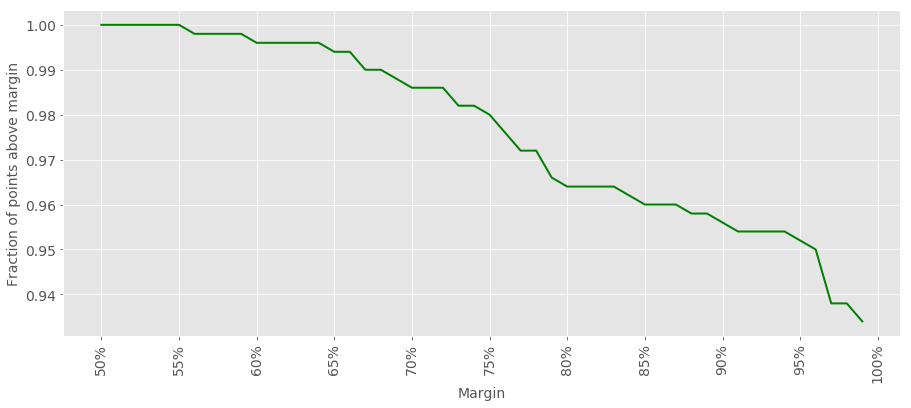

In [24]:
gammas = np.arange(0.5,1,0.01)
f = np.vectorize(lambda g: margin_counts(clf, test_data, g))
plt.figure(figsize = (15,6))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.xticks(np.arange(0.5, 1.05, 0.05),['50%','55%','60%','65%','70%','75%','80%','85%','90%','95%','100%'],rotation = 90,)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Agora nos visualizamos a distribuição do test_set para os valores de gama


In [20]:
## Retorna o  erro das predições que estão o intervalo 
def margin_errors(clf, test_data, test_labels, gamma):
    ## Computa a  probabilidade de cada ponto do test_set
    preds = clf.predict_proba(test_data)
    
    ## # Encontra os pontos para os quais a predição é de pelo menos gama
    margin_inds = np.where(np.sum(preds>gamma,axis = 1)==1)[0]
    
    ## Calcula o erro desses pontos
    num_errors = np.sum(2*np.argmax(preds[margin_inds],axis = 1)-1!=(test_labels[margin_inds]))
    return float(num_errors/margin_inds.shape[0])

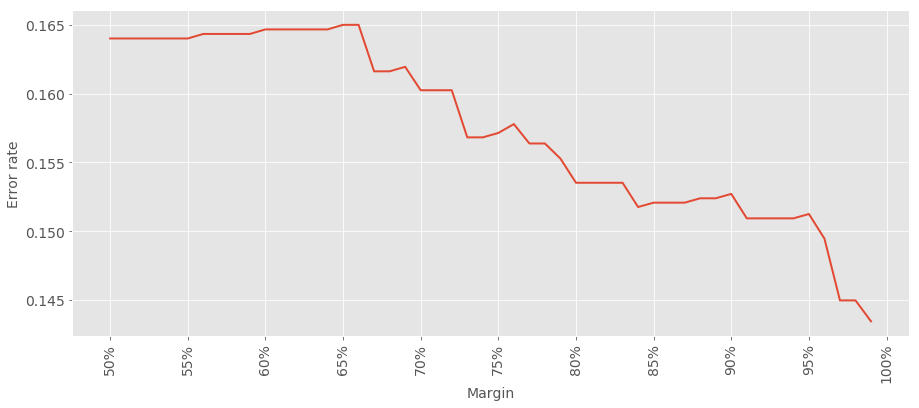

In [25]:
## Criando um set de gamas
gammas = np.arange(0.5,1,0.01)

# computa a margem de erro no set de treino para cada valor de gama
f = np.vectorize(lambda g: margin_errors(clf, test_data, test_labels, g))

## plotando os resultados
plt.figure(figsize=(15,6))
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.xticks(np.arange(0.5, 1.05, 0.05),['50%','55%','60%','65%','70%','75%','80%','85%','90%','95%','100%'],rotation = 90,)
plt.show()

<font color = 'blue' size = 3>  **7.4 Palavras que mais influenciam o classificador**</font>

Finalmente, nos tentamos **interpretar** parcialmente o modelo de regressão logistica

Quais são as palavras mais importantes para decidir se uma sentença é positiva? Como uma primeira aproximação para a resposta, nos simplesmente pegamos as palavras cujos coeficientes `w` têm os maiores valores positivos.

Por outro lado, nos olhamos para as palavras cujos coeficientes em `w` possuem os valores mais negativos e imaginamos como uma influencia negativa nas predições.

In [26]:
## Convertendo o vocabulario em lista:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Ordenando os indices de w
inds = np.argsort(w)

## palavras com os maiores valores negativos
neg_inds = inds[0:50]
print("Palavras mais Negativas: ")
print([str(x) for x in list(vocab[neg_inds])])

## palavras com os maiores valores positivos
pos_inds = inds[-49:-1]
print("Palavras mais Positivas: ")
print([str(x) for x in list(vocab[pos_inds])])

Palavras mais Negativas: 
['poor', 'worst', 'bad', 'rude', 'aren', 'disappointing', 'beep', 'unfortunately', 'bland', 'disappointment', 'then', 'wasn', 'failed', 'lacks', 'started', 'didn', 'crap', 'fly', 'fails', 'horror', 'mediocre', 'sucks', 'literally', 'return', 'avoid', 'same', 'joke', 'looks', 'waited', 'ripped', 'waste', 'not', 'terrible', 'break', 'cheap', 'talk', 'tasteless', 'doesn', 'make', 'junk', 'front', 'flavorless', 'torture', 'plot', 'imagine', 'none', 'off', 'establishment', 'odd', 'reason']
Palavras mais Positivas: 
['happy', 'friendly', 'plays', 'data', 'cult', 'happier', 'hand', 'vegas', 'ask', 'clear', 'angel', 'fast', 'fun', 'wonderful', 'sex', 'must', 'best', 'both', 'motorola', 'ray', 'charles', 'family', 'joy', 'loved', 'wow', 'delicious', 'incredible', 'cool', 'fall', 'fantastic', 'comfortable', 'scamp', 'art', 'easy', 'liked', 'amazing', 'love', 'beautiful', 'actually', 'great', 'awesome', 'funny', 'entertaining', 'works', 'nice', 'enjoyed', 'perfect', 'int